# Comparacion red neuronal regresion (refactor)

## Importar librerias

In [74]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [75]:
# Comprobar GPU y configurar memoria
print(tf.__version__)

gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU habilitada")
    except RuntimeError as e:
        print("Error al configurar GPU:", e)
else:
    print("No se detectaron GPUs")

2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU habilitada


## Importar datos

In [76]:
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame

## Analisis exploratorio de datos

In [77]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [78]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


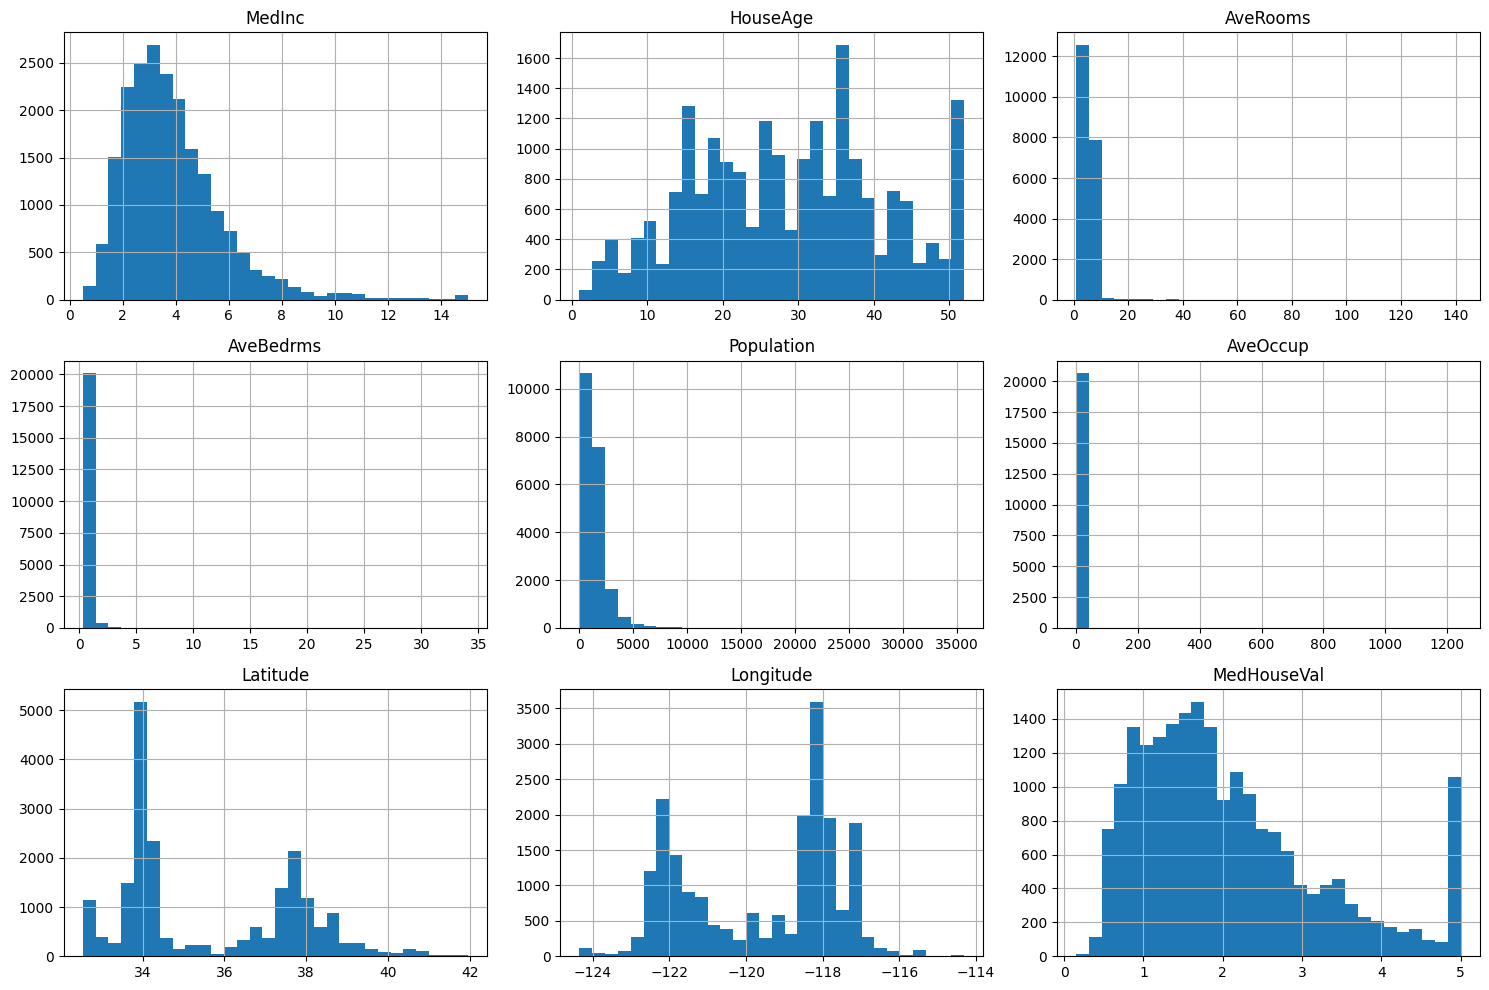

In [79]:
# Ver distribucion de las variables
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [80]:
# Definir semilla para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [81]:
# Configuracion general
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS_TUNER = 30
EPOCHS_FINAL = 120
PATIENCE_TUNER = 8
PATIENCE_FINAL = 12

output_dir = os.path.join(os.getcwd(), "models", "california_housing")

In [82]:
# Escalar los datos (features y variable objetivo)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df.drop(columns=["MedHouseVal"]))
y = df["MedHouseVal"].values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y).ravel()

In [83]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled,
    y_scaled,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## Funciones auxiliares

In [84]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    num_layers = hp.Int("num_layers", min_value=1, max_value=4, step=1)
    l2_factor = hp.Choice("l2_factor", values=[0.0, 1e-6, 1e-4])
    dropout_rate = hp.Choice("dropout_rate", values=[0.0, 0.1, 0.2, 0.3, 0.4])
    use_batch_norm = hp.Boolean("use_batch_norm")

    for i in range(num_layers):
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        activation = hp.Choice(f"activation_{i}", values=["relu", "elu"])
        model.add(
            Dense(
                units=units,
                activation=activation,
                kernel_regularizer=regularizers.l2(l2_factor)
            )
        )
        if use_batch_norm:
            model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear"))

    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=5e-3, sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

def inverse_transform_y(y_scaled, scaler):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).ravel()

def compute_mae_original(y_test_scaled, y_pred_scaled, scaler):
    y_test_real = inverse_transform_y(y_test_scaled, scaler)
    y_pred = inverse_transform_y(y_pred_scaled, scaler)
    mae = mean_absolute_error(y_test_real, y_pred)
    return mae, y_test_real, y_pred

def get_callbacks(run_tag):
    ckpt_path = os.path.join(output_dir, f"best_{run_tag}.weights.h5")
    return [
        ModelCheckpoint(filepath=ckpt_path, monitor="val_mae", save_best_only=True, save_weights_only=True),
        EarlyStopping(monitor="val_mae", patience=PATIENCE_FINAL, restore_best_weights=True)
    ]

# Variable global para almacenar resultados
resultados_comparativos = []

def run_tuner_experiment(tuner, run_tag):
    es_tuner = EarlyStopping(monitor="val_mae", patience=PATIENCE_TUNER, restore_best_weights=True)
    tuner.search(
        X_train,
        y_train_scaled,
        epochs=EPOCHS_TUNER,
        validation_data=(X_test, y_test_scaled),
        batch_size=BATCH_SIZE,
        callbacks=[es_tuner],
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"{run_tag} - mejores hiperparametros: {best_hps.values}")

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train,
        y_train_scaled,
        epochs=EPOCHS_FINAL,
        validation_data=(X_test, y_test_scaled),
        batch_size=BATCH_SIZE,
        callbacks=get_callbacks(run_tag),
        verbose=2
    )

    history_df = pd.DataFrame(history.history)
    history_df.index.name = "epoch"
    print(f"\n{run_tag} - Ultimas 15 epocas del entrenamiento:")
    display(history_df.tail(15))

    y_pred_scaled = model.predict(X_test, verbose=0).ravel()
    mae, y_test_real, y_pred = compute_mae_original(y_test_scaled, y_pred_scaled, scaler_y)
    print(f"{run_tag} - MAE en validacion (escala original): {mae:.4f}")
    
    # Guardar resultado para comparativa global
    resultados_comparativos.append({
        "Optimizador": run_tag,
        "MAE validacion": mae,
        "MAE final (escalado)": history.history["val_mae"][-1],
        "Loss final": history.history["val_loss"][-1],
        "Num capas": best_hps.get("num_layers"),
        "Learning rate": best_hps.get("learning_rate")
    })

    comparacion = pd.DataFrame({"Valor real": y_test_real, "Prediccion": y_pred})
    display(comparacion.head(10))

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_real, y_pred, alpha=0.5)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], "r--")
    plt.xlabel("Valor real")
    plt.ylabel("Prediccion")
    plt.title(f"{run_tag} - Comparacion valor real vs prediccion")
    plt.show()

    return model

## Optimizador bayesiano

Reloading Tuner from /home/jovyan/work/models/california_housing/bayesian_opt/tuner0.json
bayesian - mejores hiperparametros: {'num_layers': 4, 'l2_factor': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': False, 'units_0': 160, 'activation_0': 'relu', 'learning_rate': 0.0006415212412213298, 'units_1': 256, 'activation_1': 'elu', 'units_2': 160, 'activation_2': 'elu', 'units_3': 96, 'activation_3': 'elu'}
Epoch 1/120
516/516 - 2s - 4ms/step - loss: 0.3485 - mae: 0.4170 - val_loss: 0.2872 - val_mae: 0.3882
Epoch 2/120
516/516 - 0s - 941us/step - loss: 0.2820 - mae: 0.3767 - val_loss: 0.2681 - val_mae: 0.3724
Epoch 3/120
516/516 - 0s - 941us/step - loss: 0.2669 - mae: 0.3634 - val_loss: 0.2539 - val_mae: 0.3665
Epoch 4/120
516/516 - 0s - 923us/step - loss: 0.2440 - mae: 0.3474 - val_loss: 0.2490 - val_mae: 0.3675
Epoch 5/120
516/516 - 1s - 1ms/step - loss: 0.2341 - mae: 0.3392 - val_loss: 0.2480 - val_mae: 0.3657
Epoch 6/120
516/516 - 1s - 1ms/step - loss: 0.2283 - mae: 0.3342 - val_loss: 0.2

,loss,mae,val_loss,val_mae
epoch,,,,
33,0.180759,0.291210,0.208595,0.308518
34,0.179604,0.290307,0.209137,0.308800
35,0.178739,0.289586,0.208002,0.308187
36,0.177856,0.288845,0.208542,0.308219
37,0.176964,0.288179,0.208164,0.308459
38,0.176485,0.287489,0.208505,0.308811
39,0.175623,0.286722,0.208511,0.308969
40,0.174136,0.285853,0.208841,0.309336
41,0.173214,0.285059,0.208618,0.309333


bayesian - MAE en validacion (escala original): 0.3556


,Valor real,Prediccion
0,0.47700,0.378758
1,0.45800,0.786895
2,5.00001,5.041437
3,2.18600,2.643477
4,2.78000,2.532692
5,1.58700,1.689903
6,1.98200,2.344744
7,1.57500,1.495702
8,3.40000,3.039093
9,4.46600,4.622565


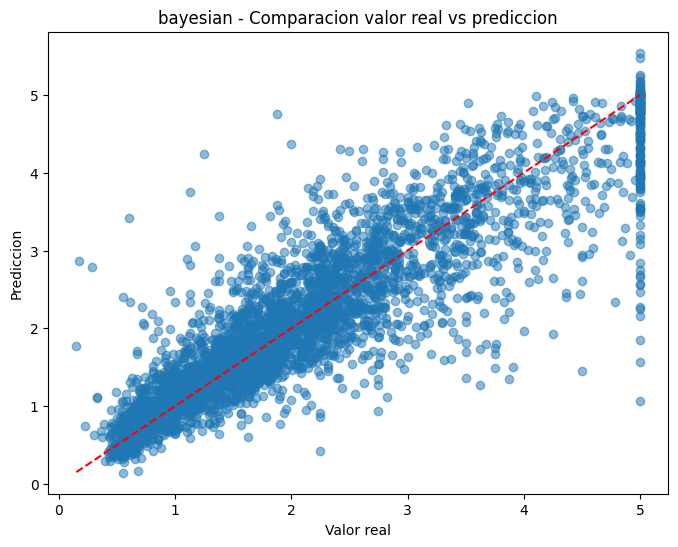

In [85]:
tuner_bayes = kt.BayesianOptimization(
    build_model,
    objective="val_mae",
    max_trials=12,
    num_initial_points=6,
    executions_per_trial=1,
    directory=output_dir,
    project_name="bayesian_opt",
)

model_bayes = run_tuner_experiment(tuner_bayes, "bayesian")

## Random search

Reloading Tuner from /home/jovyan/work/models/california_housing/random_search/tuner0.json
random - mejores hiperparametros: {'num_layers': 4, 'l2_factor': 0.0001, 'dropout_rate': 0.0, 'use_batch_norm': False, 'units_0': 96, 'activation_0': 'relu', 'learning_rate': 0.00038742095574884403, 'units_1': 32, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'relu', 'units_3': 32, 'activation_3': 'relu'}
Epoch 1/120
516/516 - 2s - 4ms/step - loss: 0.4621 - mae: 0.4800 - val_loss: 0.3299 - val_mae: 0.4018
Epoch 2/120
516/516 - 0s - 933us/step - loss: 0.3052 - mae: 0.3846 - val_loss: 0.2939 - val_mae: 0.3791
Epoch 3/120
516/516 - 0s - 936us/step - loss: 0.2768 - mae: 0.3652 - val_loss: 0.2778 - val_mae: 0.3666
Epoch 4/120
516/516 - 0s - 946us/step - loss: 0.2635 - mae: 0.3540 - val_loss: 0.2677 - val_mae: 0.3586
Epoch 5/120
516/516 - 0s - 909us/step - loss: 0.2534 - mae: 0.3451 - val_loss: 0.2583 - val_mae: 0.3499
Epoch 6/120
516/516 - 0s - 932us/step - loss: 0.2454 - mae: 0.3376 - val_lo

,loss,mae,val_loss,val_mae
epoch,,,,
78,0.180250,0.278218,0.219700,0.308299
79,0.179090,0.277501,0.220586,0.308167
80,0.178462,0.276760,0.219646,0.307476
81,0.178294,0.276669,0.220675,0.309044
82,0.178059,0.276623,0.220693,0.309442
83,0.177451,0.276130,0.220629,0.309421
84,0.177282,0.275824,0.220307,0.307916
85,0.177234,0.275921,0.220856,0.309715
86,0.177586,0.275903,0.221128,0.309649


random - MAE en validacion (escala original): 0.3548


,Valor real,Prediccion
0,0.47700,0.540260
1,0.45800,1.111009
2,5.00001,5.030486
3,2.18600,2.647807
4,2.78000,2.639325
5,1.58700,1.710763
6,1.98200,2.404268
7,1.57500,1.551838
8,3.40000,2.755418
9,4.46600,4.828814


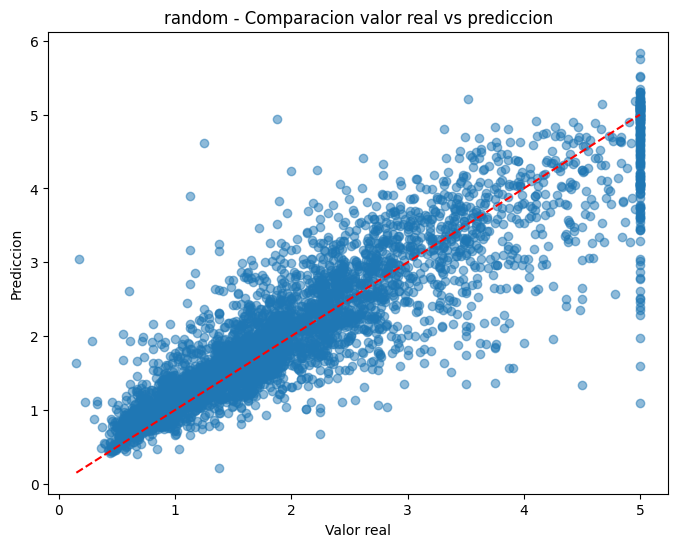

In [86]:
tuner_random = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=10,
    executions_per_trial=1,
    directory=output_dir,
    project_name="random_search",
)

model_random = run_tuner_experiment(tuner_random, "random")

## Grid search

Reloading Tuner from /home/jovyan/work/models/california_housing/grid_search/tuner0.json
grid - mejores hiperparametros: {'num_layers': 1, 'l2_factor': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': False, 'units_0': 32, 'activation_0': 'relu', 'learning_rate': 0.0019684505248725066}
Epoch 1/120
516/516 - 1s - 3ms/step - loss: 0.4376 - mae: 0.4717 - val_loss: 0.3437 - val_mae: 0.4134
Epoch 2/120
516/516 - 0s - 805us/step - loss: 0.3088 - mae: 0.3928 - val_loss: 0.3100 - val_mae: 0.3920
Epoch 3/120
516/516 - 0s - 810us/step - loss: 0.2803 - mae: 0.3757 - val_loss: 0.3026 - val_mae: 0.3821
Epoch 4/120
516/516 - 0s - 813us/step - loss: 0.2724 - mae: 0.3683 - val_loss: 0.2951 - val_mae: 0.3759
Epoch 5/120
516/516 - 0s - 803us/step - loss: 0.2671 - mae: 0.3636 - val_loss: 0.2916 - val_mae: 0.3715
Epoch 6/120
516/516 - 0s - 878us/step - loss: 0.2607 - mae: 0.3591 - val_loss: 0.2863 - val_mae: 0.3682
Epoch 7/120
516/516 - 0s - 798us/step - loss: 0.2722 - mae: 0.3600 - val_loss: 0.2836 - val_mae:

,loss,mae,val_loss,val_mae
epoch,,,,
105,0.213603,0.317210,0.222198,0.325929
106,0.218679,0.318003,0.222282,0.325274
107,0.215712,0.317260,0.220507,0.323910
108,0.211986,0.316224,0.221905,0.324665
109,0.211118,0.316135,0.220705,0.324113
110,0.210382,0.315936,0.223170,0.324575
111,0.209113,0.315318,0.221087,0.324307
112,0.208901,0.315151,0.220682,0.324265
113,0.210884,0.315776,0.221636,0.324315


grid - MAE en validacion (escala original): 0.3731


,Valor real,Prediccion
0,0.47700,0.415022
1,0.45800,0.933010
2,5.00001,4.606759
3,2.18600,2.536549
4,2.78000,3.048355
5,1.58700,1.849264
6,1.98200,2.514722
7,1.57500,1.638538
8,3.40000,2.626054
9,4.46600,4.660468


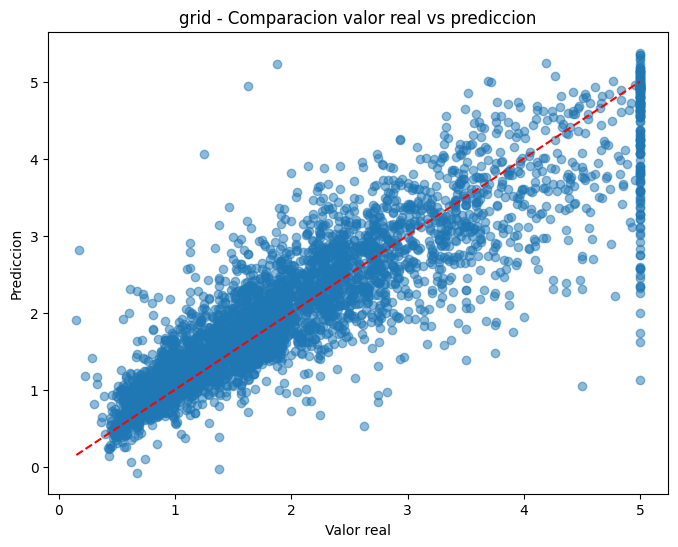

In [87]:
tuner_grid = kt.GridSearch(
    build_model,
    objective="val_mae",
    max_trials=8,
    executions_per_trial=1,
    directory=output_dir,
    project_name="grid_search",
)

model_grid = run_tuner_experiment(tuner_grid, "grid")

## Hyperband

Reloading Tuner from /home/jovyan/work/models/california_housing/hyperband/tuner0.json
hyperband - mejores hiperparametros: {'num_layers': 3, 'l2_factor': 0.0001, 'dropout_rate': 0.2, 'use_batch_norm': False, 'units_0': 96, 'activation_0': 'elu', 'learning_rate': 0.0006458571379704708, 'units_1': 224, 'activation_1': 'relu', 'units_2': 192, 'activation_2': 'relu', 'units_3': 128, 'activation_3': 'relu', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0136'}
Epoch 1/120
516/516 - 4s - 8ms/step - loss: 0.4361 - mae: 0.4646 - val_loss: 0.3400 - val_mae: 0.3879
Epoch 2/120
516/516 - 0s - 940us/step - loss: 0.3800 - mae: 0.4164 - val_loss: 0.3202 - val_mae: 0.3753
Epoch 3/120
516/516 - 0s - 946us/step - loss: 0.3539 - mae: 0.3990 - val_loss: 0.2996 - val_mae: 0.3646
Epoch 4/120
516/516 - 0s - 933us/step - loss: 0.3233 - mae: 0.3859 - val_loss: 0.2899 - val_mae: 0.3568
Epoch 5/120
516/516 - 0s - 931us/step - loss: 0.3141 - mae: 0.3783 -

,loss,mae,val_loss,val_mae
epoch,,,,
61,0.224418,0.314917,0.214748,0.295146
62,0.226083,0.318036,0.214365,0.297594
63,0.227338,0.316046,0.214276,0.294197
64,0.224706,0.315072,0.216207,0.299766
65,0.225244,0.315643,0.218016,0.302099
66,0.223568,0.314279,0.217978,0.303632
67,0.224653,0.315362,0.214799,0.295084
68,0.223153,0.312932,0.217641,0.304955
69,0.225013,0.315913,0.219551,0.303543


hyperband - MAE en validacion (escala original): 0.3395


,Valor real,Prediccion
0,0.47700,0.464518
1,0.45800,1.360462
2,5.00001,4.844054
3,2.18600,2.657074
4,2.78000,2.293308
5,1.58700,1.664891
6,1.98200,2.303633
7,1.57500,1.633643
8,3.40000,2.622698
9,4.46600,4.475647


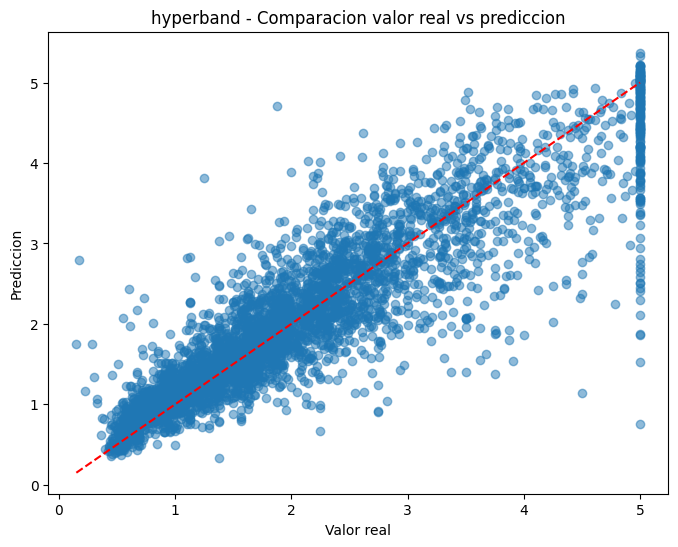

In [88]:
tuner_hb = kt.Hyperband(
    build_model,
    objective="val_mae",
    max_epochs=EPOCHS_TUNER,
    hyperband_iterations=2,
    directory=output_dir,
    project_name="hyperband",
)

model_hb = run_tuner_experiment(tuner_hb, "hyperband")

## Comparación entre los 4 optimizadores

,Optimizador,MAE validacion,MAE final (escalado),Loss final,Num capas,Learning rate
3,hyperband,0.339482,0.301966,0.218353,3,0.000646
1,random,0.354805,0.308870,0.221574,4,0.000387
0,bayesian,0.355626,0.311094,0.212170,4,0.000642
2,grid,0.373080,0.323313,0.219444,1,0.001968


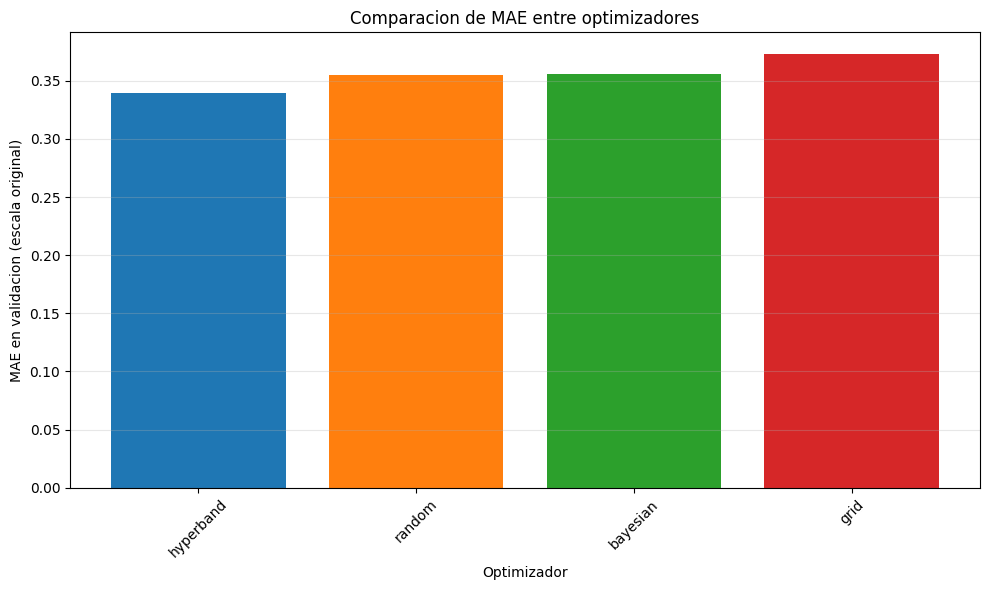


=== Resumen ===
Mejor optimizador: hyperband (MAE: 0.3395)
Peor optimizador: grid (MAE: 0.3731)
Diferencia: 0.0336


In [89]:
# Tabla comparativa de resultados
df_resultados = pd.DataFrame(resultados_comparativos)
df_resultados = df_resultados.sort_values("MAE validacion")
display(df_resultados)

# Grafico comparativo de MAE
plt.figure(figsize=(10, 6))
plt.bar(df_resultados["Optimizador"], df_resultados["MAE validacion"], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.xlabel("Optimizador")
plt.ylabel("MAE en validacion (escala original)")
plt.title("Comparacion de MAE entre optimizadores")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen 
print("\n=== Resumen ===")
print(f"Mejor optimizador: {df_resultados.iloc[0]['Optimizador']} (MAE: {df_resultados.iloc[0]['MAE validacion']:.4f})")
print(f"Peor optimizador: {df_resultados.iloc[-1]['Optimizador']} (MAE: {df_resultados.iloc[-1]['MAE validacion']:.4f})")
print(f"Diferencia: {df_resultados.iloc[-1]['MAE validacion'] - df_resultados.iloc[0]['MAE validacion']:.4f}")